## Preprocessing and dataset exploration

In [1]:
import os
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import glob

def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames based on a regex pattern in specified directory
    '''
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    
    return fns

### Set up directories

In [3]:
wd="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3"
data_dir=wd+"/data/"
model_dir=wd+"/models/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

### Download data

In [4]:
if not os.path.exists(data_dir+"yalefaces_uncropped.tar"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DNl8Dq5ozegR3ZYC6FxKTHN7GWEorENT' -O $data_dir/yalefaces_uncropped.tar   
    !tar -xvf $data_dir/yalefaces_uncropped.tar -C $data_dir
    !mv $data_dir/yalefaces $data_dir/yale_uncropped

In [5]:
if not os.path.exists(data_dir+"yalefaces_cropped.zip"):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ey7KDX70uyN7IdNA5GZlDN-Ji2aFLpq_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Ey7KDX70uyN7IdNA5GZlDN-Ji2aFLpq_" -O $data_dir/yalefaces_cropped.zip && rm -rf /tmp/cookies.txt
    !unzip $data_dir/yalefaces_cropped.zip -d $data_dir
    !rm -rf $data_dir/__MACOSX/
    !mv $data_dir/CroppedYale $data_dir/yale_cropped

In [6]:
i=15

In [7]:
# Check out data
!ls $data_dir/yale_cropped/yaleB01/ | head

yaleB01_P00A+000E+00.pgm
yaleB01_P00A+000E-20.pgm
yaleB01_P00A+000E+20.pgm
yaleB01_P00A+000E-35.pgm
yaleB01_P00A+000E+45.pgm
yaleB01_P00A+000E+90.pgm
yaleB01_P00A-005E-10.pgm
yaleB01_P00A-005E+10.pgm
yaleB01_P00A+005E-10.pgm
yaleB01_P00A+005E+10.pgm


In [8]:
cropped_fns = fn_list(data_dir+"yale_cropped/yale*", "*")
test_fn = cropped_fns[i]
test_fn

'/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3/data/yale_cropped/yaleB01/yaleB01_P00A+035E+15.pgm'

{'driver': 'PNM', 'dtype': 'uint8', 'nodata': None, 'width': 168, 'height': 192, 'count': 1, 'crs': None, 'transform': Affine(4.66956180227645e-310, 0.0, 0.0,
       6.9063077051733e-310, 4.66956181618633e-310, 6.9063077053318e-310), 'tiled': False}
(192, 168)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


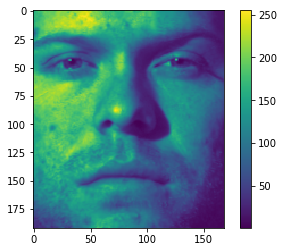

In [9]:
with rio.open(test_fn) as f:
    arr = f.read(1)
    print(f.profile)
    print(arr.shape)
plt.imshow(arr)
plt.colorbar()

In [10]:
# Check out uncropped data
!ls $data_dir/yale_uncropped/ | head

subject01.centerlight
subject01.glasses
subject01.happy
subject01.leftlight
subject01.noglasses
subject01.normal
subject01.rightlight
subject01.sad
subject01.sleepy
subject01.surprised


In [11]:
uncropped_fns = fn_list(data_dir+"yale_uncropped", "*")
test_fn = uncropped_fns[i]
test_fn

'/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3/data/yale_uncropped/subject02.noglasses'

{'driver': 'GIF', 'dtype': 'uint8', 'nodata': None, 'width': 320, 'height': 243, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
(243, 320)


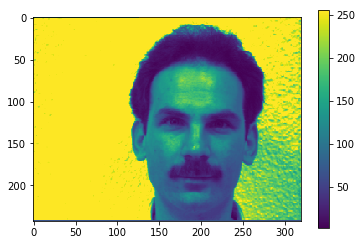

In [12]:
with rio.open(test_fn) as f:
    arr = f.read(1)
    print(f.profile)
    print(arr.shape)
plt.imshow(arr)
plt.colorbar()

In [13]:
import dask.array as da
import dask
import xarray as xr

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [14]:
%%time
first_fns=fn_list(data_dir, "yale_uncropped/*centerlight")
xr_rio = dask.delayed(xr.open_rasterio, pure=True)

# Delayed
first_lazy=[xr_rio(fn) for fn in first_fns] 

# Get template
f=first_lazy[0].compute()

# Create dask array for image cube
first_imgs=[da.from_delayed(x, 
                            shape=f.shape, 
                            dtype=f.dtype)
            for x in first_lazy]

first_imgs = [np.squeeze(np.array(x)) for x in first_imgs]
subject_labels = [ fn.split('/')[-1][:9] for fn in first_fns ]

CPU times: user 123 ms, sys: 14.3 ms, total: 138 ms
Wall time: 140 ms


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


#### Visualize the uncropped quickly

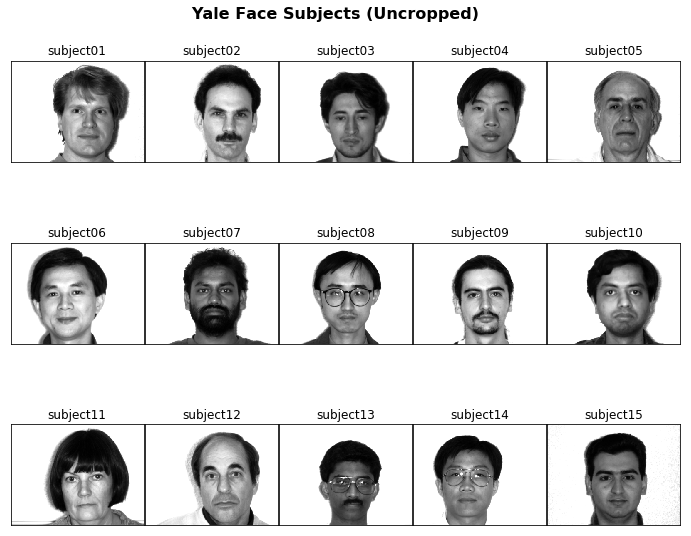

In [15]:
rows=3
cols=int(len(subject_labels)/rows)

subjects = np.unique(subject_labels) # get unique subject labels
fig, axes = plt.subplots(rows, cols, figsize=(4*rows, 2*cols), gridspec_kw=dict(hspace=0.01, wspace=0.01))

# Check out each of the subjects
idx=0

for row in range(rows):
    for col in range(cols):
        ax=axes[row, col]
#         ax.axis("off")    
        ax.set(xticks=[], yticks=[])
        img=first_imgs[idx]
        g=subjects[idx]

        # plot first image
        ax.imshow(img, cmap=plt.cm.Greys_r)
        ax.set_title(g)

        idx+=1

plt.suptitle("Yale Face Subjects (Uncropped)", fontsize=16, fontweight="bold", y=0.9);